### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [2]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [3]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [5]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [6]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

In [7]:
# 印出網路結構
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 64)       0

In [8]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [9]:
# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')

Epoch 1/150
27/27 [==============================] - ETA: 0s - loss: 0.0061
Epoch 00001: val_loss improved from inf to 0.00216, saving model to best_weights.h5
27/27 [==============================] - 4s 113ms/step - loss: 0.0061 - val_loss: 0.0022
Epoch 2/150
27/27 [==============================] - ETA: 0s - loss: 0.0016
Epoch 00002: val_loss improved from 0.00216 to 0.00188, saving model to best_weights.h5
27/27 [==============================] - 3s 110ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 3/150
27/27 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00003: val_loss did not improve from 0.00188
27/27 [==============================] - 3s 104ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 4/150
27/27 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00004: val_loss did not improve from 0.00188
27/27 [==============================] - 3s 108ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 5/150
27/27 [==============================] - ETA: 0s - los

Epoch 34/150
27/27 [==============================] - ETA: 0s - loss: 2.3022e-04
Epoch 00034: val_loss did not improve from 0.00081
27/27 [==============================] - 3s 109ms/step - loss: 2.3022e-04 - val_loss: 8.3619e-04
Epoch 35/150
27/27 [==============================] - ETA: 0s - loss: 2.2062e-04
Epoch 00035: val_loss did not improve from 0.00081
27/27 [==============================] - 3s 104ms/step - loss: 2.2062e-04 - val_loss: 8.2608e-04
Epoch 36/150
27/27 [==============================] - ETA: 0s - loss: 2.1933e-04
Epoch 00036: val_loss did not improve from 0.00081
27/27 [==============================] - 3s 110ms/step - loss: 2.1933e-04 - val_loss: 8.1821e-04
Epoch 37/150
27/27 [==============================] - ETA: 0s - loss: 2.2130e-04
Epoch 00037: val_loss did not improve from 0.00081
27/27 [==============================] - 3s 107ms/step - loss: 2.2130e-04 - val_loss: 8.4179e-04
Epoch 38/150
27/27 [==============================] - ETA: 0s - loss: 2.1847e-04
Epo

Epoch 69/150
27/27 [==============================] - ETA: 0s - loss: 1.5583e-04
Epoch 00069: val_loss did not improve from 0.00076
27/27 [==============================] - 3s 94ms/step - loss: 1.5583e-04 - val_loss: 7.9925e-04
Epoch 70/150
27/27 [==============================] - ETA: 0s - loss: 1.5037e-04
Epoch 00070: val_loss did not improve from 0.00076
27/27 [==============================] - 3s 94ms/step - loss: 1.5037e-04 - val_loss: 7.8647e-04
Epoch 71/150
27/27 [==============================] - ETA: 0s - loss: 1.4446e-04
Epoch 00071: val_loss did not improve from 0.00076
27/27 [==============================] - 3s 95ms/step - loss: 1.4446e-04 - val_loss: 7.8287e-04
Epoch 72/150
27/27 [==============================] - ETA: 0s - loss: 1.4167e-04
Epoch 00072: val_loss did not improve from 0.00076
27/27 [==============================] - 3s 95ms/step - loss: 1.4167e-04 - val_loss: 8.0027e-04
Epoch 73/150
27/27 [==============================] - ETA: 0s - loss: 1.4151e-04
Epoch 0

Epoch 105/150
27/27 [==============================] - ETA: 0s - loss: 1.1389e-04
Epoch 00105: val_loss did not improve from 0.00075
27/27 [==============================] - 3s 93ms/step - loss: 1.1389e-04 - val_loss: 8.0315e-04
Epoch 106/150
27/27 [==============================] - ETA: 0s - loss: 1.1213e-04
Epoch 00106: val_loss did not improve from 0.00075
27/27 [==============================] - 3s 93ms/step - loss: 1.1213e-04 - val_loss: 8.0910e-04
Epoch 107/150
27/27 [==============================] - ETA: 0s - loss: 1.0612e-04
Epoch 00107: val_loss did not improve from 0.00075
27/27 [==============================] - 3s 94ms/step - loss: 1.0612e-04 - val_loss: 7.7913e-04
Epoch 108/150
27/27 [==============================] - ETA: 0s - loss: 1.0712e-04
Epoch 00108: val_loss did not improve from 0.00075
27/27 [==============================] - 2s 93ms/step - loss: 1.0712e-04 - val_loss: 7.7880e-04
Epoch 109/150
27/27 [==============================] - ETA: 0s - loss: 1.0738e-04
Ep

Epoch 141/150
27/27 [==============================] - ETA: 0s - loss: 8.9300e-05
Epoch 00141: val_loss did not improve from 0.00075
27/27 [==============================] - 3s 93ms/step - loss: 8.9300e-05 - val_loss: 7.9121e-04
Epoch 142/150
27/27 [==============================] - ETA: 0s - loss: 8.9144e-05
Epoch 00142: val_loss did not improve from 0.00075
27/27 [==============================] - 3s 94ms/step - loss: 8.9144e-05 - val_loss: 7.5175e-04
Epoch 143/150
27/27 [==============================] - ETA: 0s - loss: 9.2272e-05
Epoch 00143: val_loss did not improve from 0.00075
27/27 [==============================] - 3s 93ms/step - loss: 9.2272e-05 - val_loss: 7.6703e-04
Epoch 144/150
27/27 [==============================] - ETA: 0s - loss: 9.1269e-05
Epoch 00144: val_loss did not improve from 0.00075
27/27 [==============================] - 3s 94ms/step - loss: 9.1269e-05 - val_loss: 7.6920e-04
Epoch 145/150
27/27 [==============================] - ETA: 0s - loss: 8.6349e-05
Ep

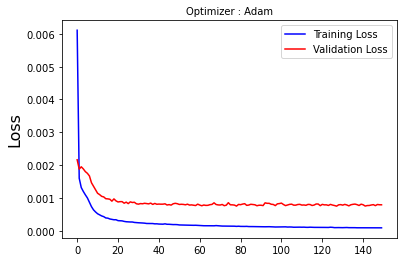

In [10]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

### 觀察 model 在 testing 上的結果

In [11]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = 'test.csv')

In [12]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

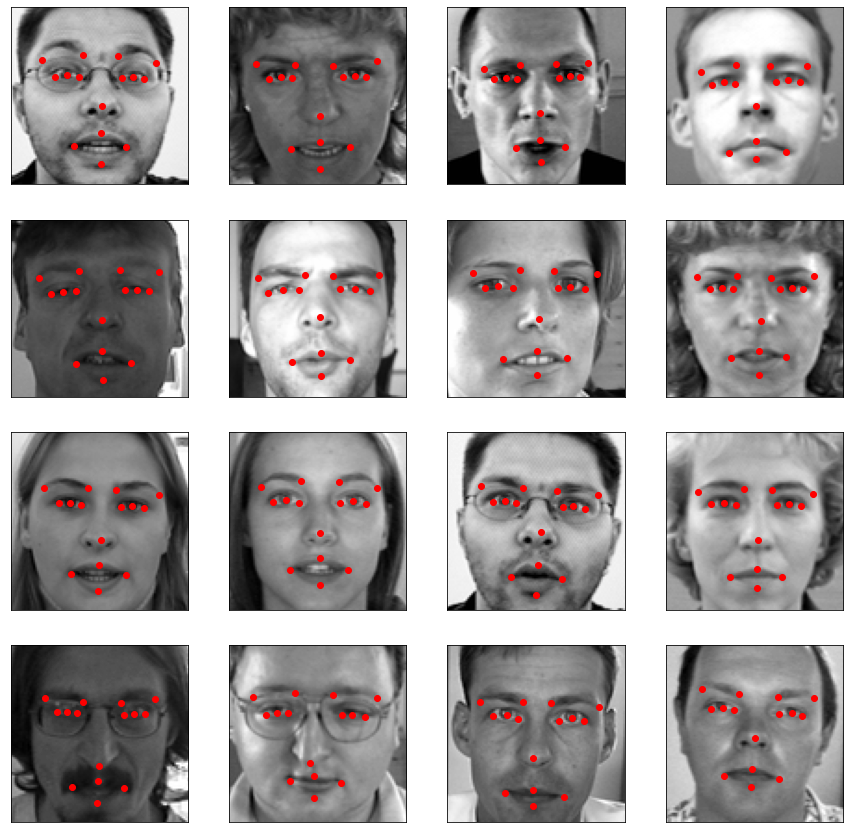

In [13]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))